In [1]:
!pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: soham27
Your Kaggle Key: ··········


  2%|▏         | 9.00M/395M [00:00<00:04, 90.1MB/s]

100%|██████████| 395M/395M [00:01<00:00, 245MB/s]


In [5]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [6]:
print(os.listdir(DATA_DIR+'/images')[:10])

['11753_2005.jpg', '62166_2019.jpg', '41235_2013.jpg', '3660_2002.jpg', '59527_2018.jpg', '4833_2003.jpg', '2842_2002.jpg', '26002_2009.jpg', '30853_2010.jpg', '61892_2019.jpg']


In [7]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [8]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [10]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [15]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

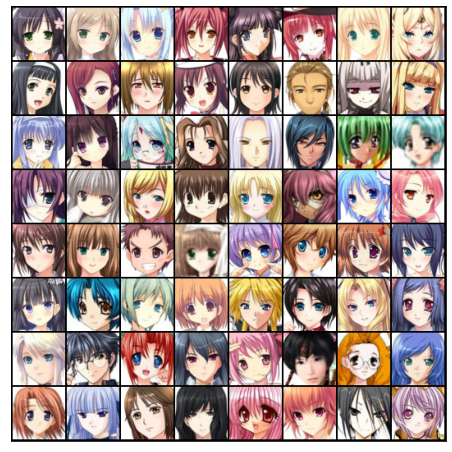

In [16]:
show_batch(train_dl)

**Using a GPU** 

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
train_dl = DeviceDataLoader(train_dl, device)

**Discriminator Network**

In [20]:
import torch.nn as nn

In [21]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [22]:
discriminator = to_device(discriminator, device)

**Generator Network**

In [23]:
latent_size = 128

In [24]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


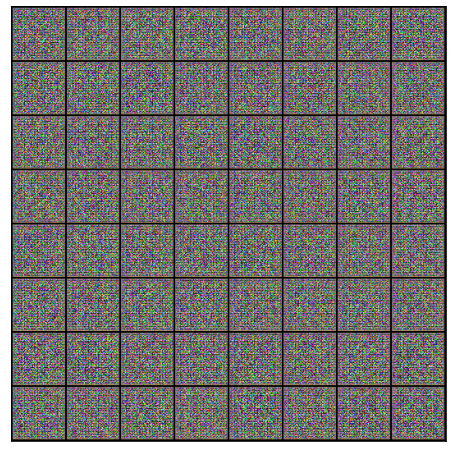

In [25]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [26]:
generator = to_device(generator, device)

**Discriminator Training**

In [27]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score


**Generator Training**

In [28]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()


In [29]:
from torchvision.utils import save_image

In [30]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [31]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [32]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


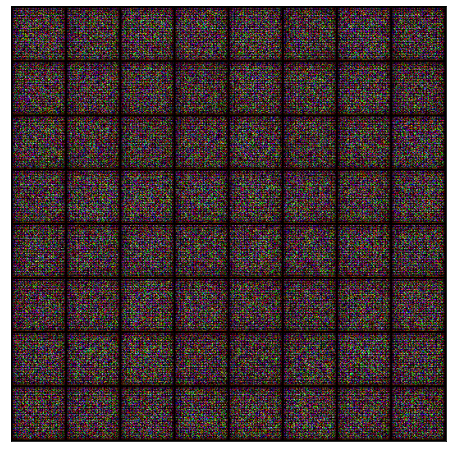

In [33]:
save_samples(0, fixed_latent)

In [34]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

**Training**

In [37]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [38]:
lr = 0.0002
epochs = 40

In [39]:
history = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/40], loss_g: 8.0632, loss_d: 1.0401, real_score: 0.8635, fake_score: 0.5350
Saving generated-images-0001.png



Epoch [2/40], loss_g: 4.0688, loss_d: 0.3802, real_score: 0.8769, fake_score: 0.1938
Saving generated-images-0002.png



Epoch [3/40], loss_g: 4.4416, loss_d: 0.3510, real_score: 0.8606, fake_score: 0.1540
Saving generated-images-0003.png



Epoch [4/40], loss_g: 3.3147, loss_d: 0.1628, real_score: 0.8954, fake_score: 0.0360
Saving generated-images-0004.png



Epoch [5/40], loss_g: 6.5895, loss_d: 0.1758, real_score: 0.8697, fake_score: 0.0093
Saving generated-images-0005.png



Epoch [6/40], loss_g: 4.4892, loss_d: 0.0702, real_score: 0.9467, fake_score: 0.0113
Saving generated-images-0006.png



Epoch [7/40], loss_g: 5.0868, loss_d: 0.0358, real_score: 0.9750, fake_score: 0.0053
Saving generated-images-0007.png



Epoch [8/40], loss_g: 4.6391, loss_d: 0.1629, real_score: 0.9103, fake_score: 0.0460
Saving generated-images-0008.png



Epoch [9/40], loss_g: 3.6938, loss_d: 0.0302, real_score: 0.9997, fake_score: 0.0283
Saving generated-images-0009.png



Epoch [10/40], loss_g: 5.9717, loss_d: 0.1830, real_score: 0.9130, fake_score: 0.0528
Saving generated-images-0010.png



Epoch [11/40], loss_g: 7.2886, loss_d: 0.1225, real_score: 0.9707, fake_score: 0.0742
Saving generated-images-0011.png



Epoch [12/40], loss_g: 7.0507, loss_d: 0.0480, real_score: 0.9615, fake_score: 0.0052
Saving generated-images-0012.png



Epoch [13/40], loss_g: 9.6702, loss_d: 0.2162, real_score: 0.9658, fake_score: 0.1504
Saving generated-images-0013.png



Epoch [14/40], loss_g: 6.7619, loss_d: 0.1622, real_score: 0.8866, fake_score: 0.0042
Saving generated-images-0014.png



Epoch [15/40], loss_g: 17.0391, loss_d: 0.1938, real_score: 0.8833, fake_score: 0.0000
Saving generated-images-0015.png



Epoch [16/40], loss_g: 6.7060, loss_d: 0.0669, real_score: 0.9905, fake_score: 0.0533
Saving generated-images-0016.png



Epoch [17/40], loss_g: 6.8689, loss_d: 0.0880, real_score: 0.9770, fake_score: 0.0607
Saving generated-images-0017.png



Epoch [18/40], loss_g: 5.3534, loss_d: 0.1264, real_score: 0.9547, fake_score: 0.0642
Saving generated-images-0018.png



Epoch [19/40], loss_g: 4.9917, loss_d: 0.1121, real_score: 0.9172, fake_score: 0.0111
Saving generated-images-0019.png



Epoch [20/40], loss_g: 9.3284, loss_d: 0.1470, real_score: 0.9750, fake_score: 0.0918
Saving generated-images-0020.png



Epoch [21/40], loss_g: 17.9886, loss_d: 0.0129, real_score: 0.9888, fake_score: 0.0009
Saving generated-images-0021.png



Epoch [22/40], loss_g: 5.8977, loss_d: 0.0472, real_score: 0.9799, fake_score: 0.0233
Saving generated-images-0022.png



Epoch [23/40], loss_g: 7.8854, loss_d: 0.1083, real_score: 0.9736, fake_score: 0.0687
Saving generated-images-0023.png



Epoch [24/40], loss_g: 4.7089, loss_d: 0.1076, real_score: 0.9171, fake_score: 0.0040
Saving generated-images-0024.png



Epoch [25/40], loss_g: 7.1926, loss_d: 0.0744, real_score: 0.9952, fake_score: 0.0655
Saving generated-images-0025.png



Epoch [26/40], loss_g: 7.2631, loss_d: 0.0122, real_score: 0.9986, fake_score: 0.0106
Saving generated-images-0026.png



Epoch [27/40], loss_g: 10.9076, loss_d: 0.0432, real_score: 0.9784, fake_score: 0.0181
Saving generated-images-0027.png



Epoch [28/40], loss_g: 8.5754, loss_d: 0.0221, real_score: 0.9939, fake_score: 0.0155
Saving generated-images-0028.png



Epoch [29/40], loss_g: 5.5108, loss_d: 0.0888, real_score: 0.9487, fake_score: 0.0163
Saving generated-images-0029.png



Epoch [30/40], loss_g: 5.7027, loss_d: 0.0476, real_score: 0.9780, fake_score: 0.0200
Saving generated-images-0030.png



Epoch [31/40], loss_g: 7.3951, loss_d: 0.0572, real_score: 0.9977, fake_score: 0.0517
Saving generated-images-0031.png



Epoch [32/40], loss_g: 9.2697, loss_d: 0.1163, real_score: 0.9916, fake_score: 0.0992
Saving generated-images-0032.png



Epoch [33/40], loss_g: 8.6582, loss_d: 0.1565, real_score: 0.9240, fake_score: 0.0314
Saving generated-images-0033.png



Epoch [34/40], loss_g: 15.6679, loss_d: 0.0136, real_score: 0.9904, fake_score: 0.0035
Saving generated-images-0034.png



Epoch [35/40], loss_g: 5.5377, loss_d: 0.0763, real_score: 0.9678, fake_score: 0.0311
Saving generated-images-0035.png



Epoch [36/40], loss_g: 23.6913, loss_d: 0.0003, real_score: 0.9999, fake_score: 0.0002
Saving generated-images-0036.png



Epoch [37/40], loss_g: 6.5191, loss_d: 0.0378, real_score: 0.9905, fake_score: 0.0272
Saving generated-images-0037.png



Epoch [38/40], loss_g: 3.8019, loss_d: 0.1438, real_score: 0.9132, fake_score: 0.0247
Saving generated-images-0038.png



Epoch [39/40], loss_g: 21.8616, loss_d: 0.0622, real_score: 0.9777, fake_score: 0.0092
Saving generated-images-0039.png



Epoch [40/40], loss_g: 13.3594, loss_d: 0.0433, real_score: 0.9973, fake_score: 0.0351
Saving generated-images-0040.png


In [40]:
losses_g, losses_d, real_scores, fake_scores = history

In [41]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [42]:
from IPython.display import Image

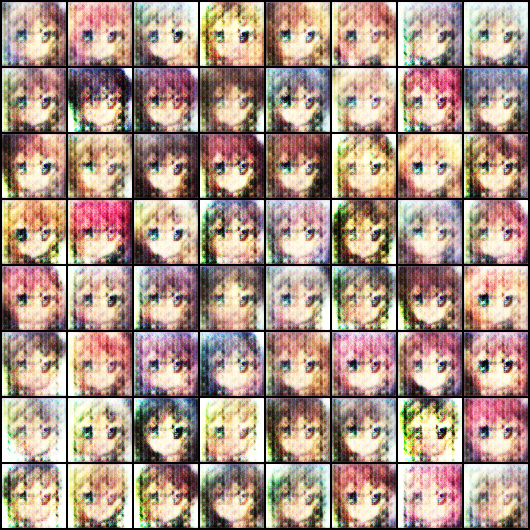

In [43]:
Image('./generated/generated-images-0001.png')


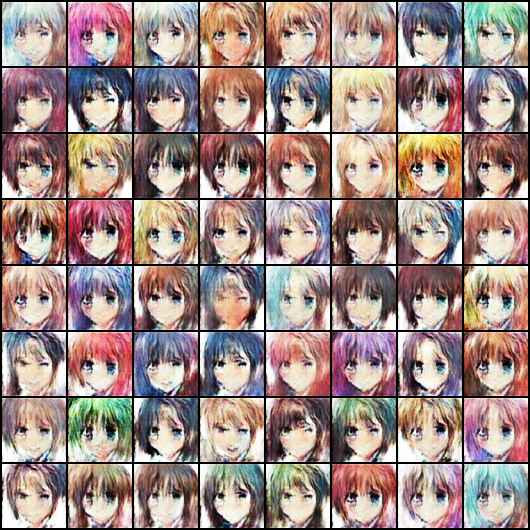

In [45]:
Image('./generated/generated-images-0005.png')

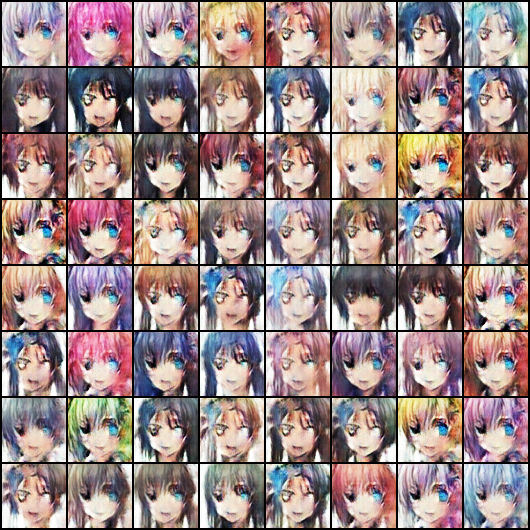

In [46]:
Image('./generated/generated-images-0010.png')

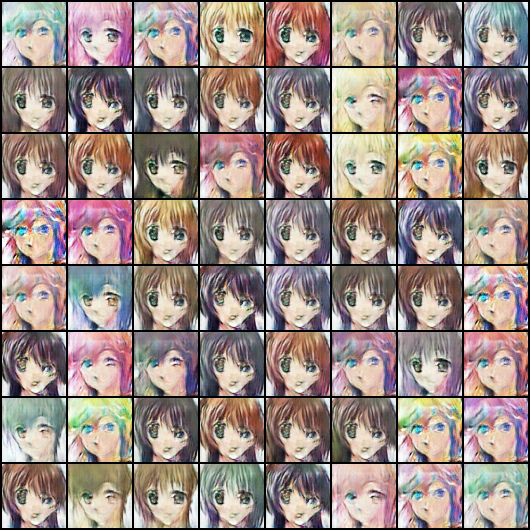

In [47]:
Image('./generated/generated-images-0025.png')

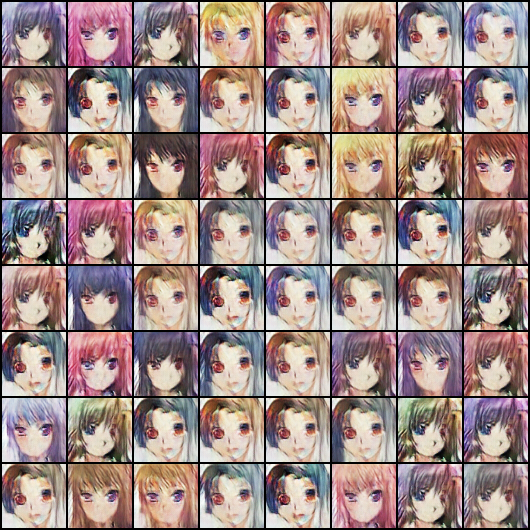

In [48]:
Image('./generated/generated-images-0031.png')

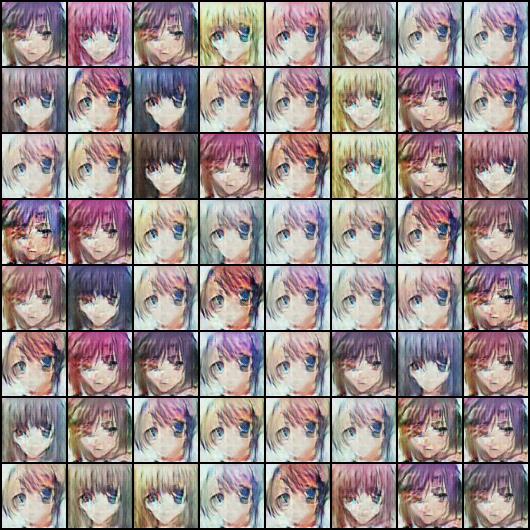

In [49]:
Image('./generated/generated-images-0040.png')

In [53]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 2, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

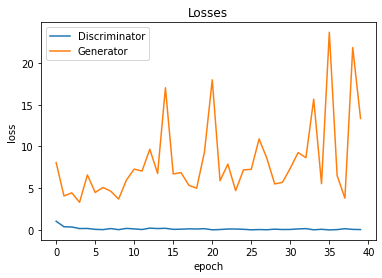

In [51]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

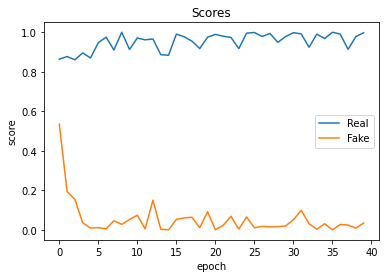

In [52]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');